## 线性回归示例：颜值打分

In [1]:
# 代码4-1：读入Y数据
import pandas as pd
MasterFile=pd.read_csv('../dataset/faces/FaceScore.csv')  # 读取数据文件
print(MasterFile.shape)
MasterFile[0:5] # 查看数据文件

(5500, 2)


,Filename,Rating
0,ftw1.jpg,4.083333
1,ftw10.jpg,3.666667
2,ftw100.jpg,1.916667
3,ftw101.jpg,2.416667
4,ftw102.jpg,3.166667


array([[<Axes: title={'center': 'Rating'}>]], dtype=object)

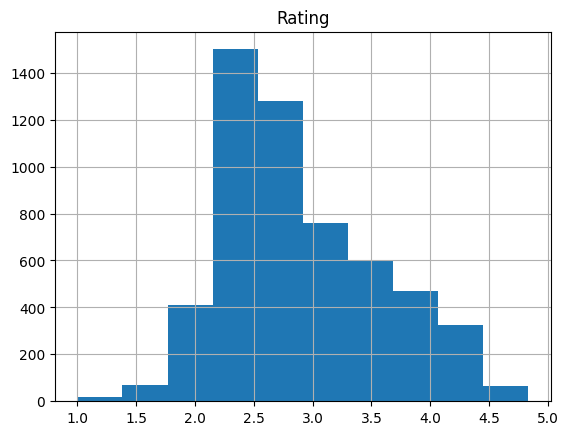

In [2]:
# 代码4-2：绘制直方图
import matplotlib.pylab as plt
MasterFile.hist() # 绘制直方图

In [3]:
# 代码4-3：构建Dataset类
from PIL import Image
import numpy as np
from itertools import islice

def default_loader(path):
    return Image.open(path) #根据图片路径读取图片

class Dataset():
    def __init__(self, loader=default_loader, transform=None):
        with open('../dataset/faces/FaceScore.csv', 'r') as f:
            imgs = []
            for line in islice(f, 1, None): # 跳过csv文件首行的标题
                line = line.strip('\n') # 去除末尾换行符
                line = line.split(',') # 将一行拆分成图片名称和颜值打分数
                im = '../dataset/faces/images/' + line[0] # 图片路径
                imgs.append((im, float(line[1])))    
        self.imgs = imgs
        self.loader = loader
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        images, labels = self.imgs[index]
        img = self.loader(images)
        img = self.transform(img)
        return img, labels

from torchvision import datasets, transforms
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.Resize((128, 128)), # 变形为网络所需的输入形状（ 128 * 128）
    transforms.ToTensor(), # 转换为tensor（注意，此处的tensor默认在CPU上储存）
])

# 根据Dataset长度设置训练集和验证集的划分长度
full_data = Dataset(transform=transform)
train_size = int(len(full_data) * 0.8)  # 这里train_size是一个长度矢量，并非是比例，我们将训练和测试进行8/2划分
val_size = len(full_data) - train_size
 
# 从Dataset随机划分训练集和验证集 
train_set, val_set = random_split(full_data, [train_size, val_size])

In [4]:
# 代码4-4：构建数据读取器
import torch
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size, shuffle=True, num_workers=4)  # 训练集进行打乱
val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=batch_size, shuffle=False, num_workers=4)  # 测试集不进行打乱

torch.Size([8, 3, 128, 128])
torch.Size([8])


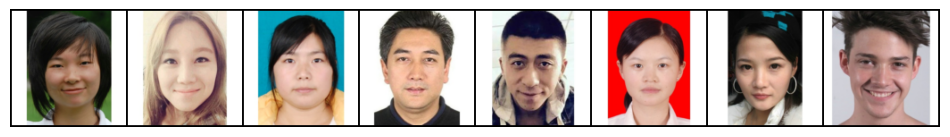

In [5]:
# 代码4-5：展示训练集中第一个批次的图像
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
images, labels = next(iter(train_loader))  # 获取训练集第一个批次中的图片及相应标签
print(images.shape)
print(labels.shape)
plt.figure(figsize=(12, 20))  # 设置画布大小
plt.axis('off')  # 隐藏坐标轴
plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))  # make_grid函数把多张图片一起显示，permute函数调换channel维的顺序
plt.show()

In [7]:
# 代码4-6：构建线性回归模型
import torch
import torch.nn as nn
from torchsummary import summary

class LinearRegression(torch.nn.Module):
    def __init__(self):
        super(LinearRegression,self).__init__()
        self.layer1 = torch.nn.Linear(128 * 128 * 3, 1)
    def forward(self, x):
        x = x.reshape(-1, 128 * 128 * 3) # 将输入拉直成128*128*3的向量，其中-1代表根据已经确定的128*128*3维度，自动计算x第一个shape属性。
        x = self.layer1(x)
        return x
    
# 查看模型具体信息
from torchsummary import summary  # 需要预先下载，在终端输入 pip install torchsummary
IMSIZE = 128
linearregression_model = LinearRegression().cuda()
# summary的第一个从参数为模型，第二个参数为输入的尺寸（3维立体矩阵）
summary(linearregression_model, (3, IMSIZE, IMSIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]          49,153
Total params: 49,153
Trainable params: 49,153
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.00
Params size (MB): 0.19
Estimated Total Size (MB): 0.38
----------------------------------------------------------------


In [8]:
# 代码4-7：模型训练
device = "cuda" #指定设备为gpu
def mse_metric(outputs, labels):
    return torch.sum(pow((outputs.view(-1) - labels), 2)) / len(outputs.view(-1)) # 计算均方误差

# 模型验证
def validate(model, val_loader):
    val_loss = 0
    val_mse = 0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
        outputs = model(inputs)  # 计算模型输出
        loss = torch.nn.MSELoss()(outputs.view(-1), labels.to(torch.float32))  # 计算均方误差损失函数
        val_loss += loss.item()  # item方法提取出tensor中的数字
        mse = mse_metric(outputs, labels)  # 计算均方误差
        val_mse += mse
    val_loss /= len(val_loader)  # 计算平均损失
    val_mse /= len(val_loader)  # 计算平均均方误差
    return val_loss, val_mse

# 打印训练结果
def print_log(epoch, train_time, train_loss, train_mse, val_loss, val_mse, epochs=10):
    print(f"Epoch [{epoch}/{epochs}], time: {train_time:.2f}s, loss: {train_loss:.4f}, mse: {train_mse:.4f}, val_loss: {val_loss:.4f}, val_mse: {val_mse:.4f}")

import time
# 定义主函数：模型训练
def train(model, optimizer, train_loader, val_loader, epochs=1):
    train_losses = []; train_mses = [];
    val_losses = []; val_mses = [];
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        train_mse = 0
        start = time.time()  # 记录本epoch开始时间
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
            optimizer.zero_grad()  # 将模型所有参数tensor的梯度变为0（否则之后计算的梯度会与先前存在的梯度叠加）
            outputs = model(inputs)  # 计算模型输出
            loss = torch.nn.MSELoss()(outputs.view(-1), labels.to(torch.float32))  # 计算损失函数
            train_loss += loss.item()  # item方法提取出tensor中的数字
            mse = mse_metric(outputs, labels)  # 计算均方误差
            train_mse += mse
            loss.backward()  # 调用PyTorch的autograd自动求导功能，计算loss相对于模型各参数的导数
            optimizer.step()  # 根据模型中各参数相对于loss的导数，以及指定的学习率，更新参数
            
        end = time.time()  # 记录本epoch结束时间
        train_time = end - start  # 计算本epoch的训练耗时 
        train_loss /= len(train_loader)  # 计算平均损失
        train_mse /= len(train_loader)  # 计算平均均方误差
        val_loss, val_mse = validate(model, val_loader)  # 计算测试集上的损失函数和准确
        train_losses.append(train_loss); train_mses.append(train_mse)
        val_losses.append(val_loss); val_mses.append(val_mse) 
        print_log(epoch + 1, train_time, train_loss, train_mse, val_loss, val_mse, epochs=epochs)  # 打印训练结果
    return train_losses, train_mses, val_losses, val_mses

lr = 1e-3
epochs = 1
optimizer = torch.optim.Adam(linearregression_model.parameters(), lr=lr)  # 设置优化器
history = train(linearregression_model, optimizer, train_loader, val_loader, epochs=epochs)  # 实施训练

Epoch [1/1], time: 48.71s, loss: 7.3723, mse: 7.3723, val_loss: 0.4388, val_mse: 0.4388


神经网络猜测图片颜值打分是 1.2873287200927734, 实际得分是 3.0


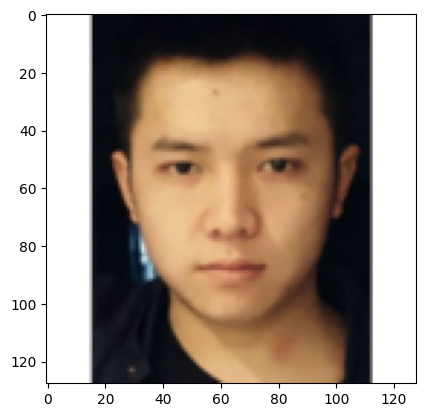

In [9]:
# 代码4-8： 模型预测
# 挑选valloader中的一张图片作为测试
dataiter = iter(val_loader)
images, labels = images, labels =next(dataiter)
img = images[4].permute((1, 2, 0))
lbl = labels[4]
plt.imshow(img)
# 将测试图片转为一维的列向量
img = torch.from_numpy(img.numpy())
img = img.reshape(1, 128 * 128 * 3)

# 进行正向推断，预测图片所在的类别
with torch.no_grad():
    output = linearregression_model.forward(img.to(device))
    
prediction = float(output)
print(f'神经网络猜测图片颜值打分是 {prediction}, 实际得分是 {lbl}')

## 逻辑回归案例：性别识别

In [10]:
# 代码4-9：构建Dataset类
from PIL import Image
from itertools import islice

def default_loader(path):
    return Image.open(path)

class Dataset():
    def __init__(self, loader=default_loader, transform=None):
        with open('../dataset/faces/FaceScore.csv', 'r') as f: # 读取csv文件
            imgs = []
            for line in islice(f, 1, None):# 跳过标题行
                line = line.strip('\n')
                line = line.split(',')
                im = '../dataset/faces/images/' + line[0]
                gender = (line[0])[0]
                if gender == 'm': # m代表男性，赋值为1，否则是女性，赋值为0
                    lbl = 1
                else:
                    lbl = 0
                imgs.append((im, lbl))
        self.imgs = imgs
        self.loader = loader
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        images,labels = self.imgs[index]
        img = self.loader(images)
        img = self.transform(img)
        return img, labels

from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)), # 变形为网络所需的输入形状（ 28 * 28）
    transforms.ToTensor() # 转换为tensor（注意，此处的tensor默认在CPU上储存）
])

# 根据Dataset长度设置训练集和验证集的划分长度
full_data = Dataset(transform=transform)
train_size = int(len(full_data) * 0.8)  # 这里train_size是一个长度矢量，并非是比例，我们将训练和测试进行8/2划分
val_size = len(full_data) - train_size

# 从Dataset随机划分训练集和验证集 
train_set, val_set = random_split(full_data, [train_size, val_size])

In [11]:
# 代码4-10：构建数据读取器
import torch
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size, shuffle=True, num_workers=4)  # 训练集进行打乱
val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=batch_size, shuffle=False, num_workers=4)  # 测试集不进行打乱

torch.Size([8, 3, 128, 128])
torch.Size([8])


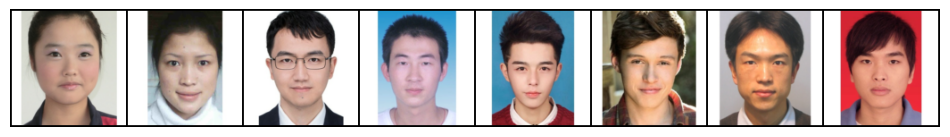

In [12]:
# 代码4-11：展示第一个批次的图像
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
images, labels = next(iter(train_loader))  # 获取训练集第一个批次中的图片及相应标签
print(images.shape)
print(labels.shape)
plt.figure(figsize=(12, 20))  # 设置画布大小
plt.axis('off')  # 隐藏坐标轴
plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))  # make_grid函数把多张图片一起显示，permute函数调换channel维的顺序
plt.show()

In [13]:
# 代码4-12 ：逻辑回归模型构建
# 导入相关模块
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 构建逻辑回归模型
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(128 * 128 * 3, 2)
    
    def forward(self, x):
        x = x.reshape(-1, 128 * 128 * 3)
        x = self.linear(x)
        # x = F.log_softmax(x, dim=1)
        return x

In [14]:
## 查看模型具体信息
from torchsummary import summary  # 需要预先下载，在终端输入 pip install torchsummary
IMSIZE = 128
logisticregression_model = LogisticRegression().cuda()
# summary的第一个从参数为模型，第二个参数为输入的尺寸（3维）
summary(logisticregression_model, (3, IMSIZE, IMSIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 2]          98,306
Total params: 98,306
Trainable params: 98,306
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.00
Params size (MB): 0.38
Estimated Total Size (MB): 0.56
----------------------------------------------------------------


In [15]:
# 代码4-13： 模型训练
device = "cuda"
def accuracy(outputs, labels):
    preds = torch.max(outputs, dim=1)[1]  # 获取预测类别
    return torch.sum(preds == labels).item() / len(preds)  # 计算准确率

# 模型验证
def validate(model, val_loader):
    val_loss = 0
    val_acc = 0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
        outputs = model(inputs)  # 计算模型输出
        loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
        val_loss += loss.item()  # item方法提取出tensor中的数字
        acc = accuracy(outputs, labels)  # 计算准确率
        val_acc += acc
    val_loss /= len(val_loader)  # 计算平均损失
    val_acc /= len(val_loader)  # 计算平均准确率
    return val_loss, val_acc

# 打印训练结果
def print_log(epoch, train_time, train_loss, train_acc, val_loss, val_acc, epochs=10):
    print(f"Epoch [{epoch}/{epochs}], time: {train_time:.2f}s, loss: {train_loss:.4f}, acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

In [16]:
# 定义主函数：模型训练
import time
def train(model,optimizer, train_loader, val_loader, epochs=1):
    train_losses = []; train_accs = [];
    val_losses = []; val_accs = [];
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        train_acc = 0
        start = time.time()  # 记录本epoch开始时间
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
            optimizer.zero_grad()  # 将模型所有参数tensor的梯度变为0（否则之后计算的梯度会与先前存在的梯度叠加）
            outputs = model(inputs)  # 计算模型输出
            labels = labels.long()
            loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
            train_loss += loss.item()  # item方法提取出tensor中的数字
            acc = accuracy(outputs, labels)  # 计算准确率
            train_acc += acc
            loss.backward()  # 调用PyTorch的autograd自动求导功能，计算loss相对于模型各参数的导数
            optimizer.step()  # 根据模型中各参数相对于loss的导数，以及指定的学习率，更新参数
        end = time.time()  # 记录本epoch结束时间
        train_time = end - start  # 计算本epoch的训练耗时 
        train_loss /= len(train_loader)  # 计算平均损失
        train_acc /= len(train_loader)  # 计算平均准确率 
        val_loss, val_acc = validate(model, val_loader)  # 计算测试集上的损失函数和准确
        train_losses.append(train_loss); train_accs.append(train_acc)
        val_losses.append(val_loss); val_accs.append(val_acc) 
        print_log(epoch + 1, train_time, train_loss, train_acc, val_loss, val_acc, epochs=epochs)  # 打印训练结果
    return train_losses, train_accs, val_losses, val_accs

lr = 1e-4
epochs = 10
optimizer = torch.optim.Adam(logisticregression_model.parameters(), lr=lr)  # 设置优化器
history = train(logisticregression_model, optimizer, train_loader, val_loader, epochs=epochs)  # 实施训练

Epoch [1/10], time: 3.50s, loss: 0.6026, acc: 0.7314, val_loss: 0.4889, val_acc: 0.7953
Epoch [2/10], time: 3.47s, loss: 0.4703, acc: 0.7916, val_loss: 0.4531, val_acc: 0.8080
Epoch [3/10], time: 3.46s, loss: 0.5022, acc: 0.7975, val_loss: 0.3987, val_acc: 0.8415
Epoch [4/10], time: 3.45s, loss: 0.4441, acc: 0.8170, val_loss: 0.3923, val_acc: 0.8216
Epoch [5/10], time: 3.50s, loss: 0.4417, acc: 0.8218, val_loss: 0.3569, val_acc: 0.8533
Epoch [6/10], time: 3.52s, loss: 0.4489, acc: 0.8170, val_loss: 0.6564, val_acc: 0.7446
Epoch [7/10], time: 3.48s, loss: 0.4425, acc: 0.8243, val_loss: 0.5304, val_acc: 0.7808
Epoch [8/10], time: 3.53s, loss: 0.4103, acc: 0.8398, val_loss: 0.3740, val_acc: 0.8533
Epoch [9/10], time: 3.45s, loss: 0.4394, acc: 0.8309, val_loss: 0.3540, val_acc: 0.8560
Epoch [10/10], time: 3.75s, loss: 0.3820, acc: 0.8507, val_loss: 0.4027, val_acc: 0.8533


/tmp/ipykernel_120/268368368.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probability = float(F.softmax(output).max())


神经网络猜测图片里是女性，概率为78.70587110519409%


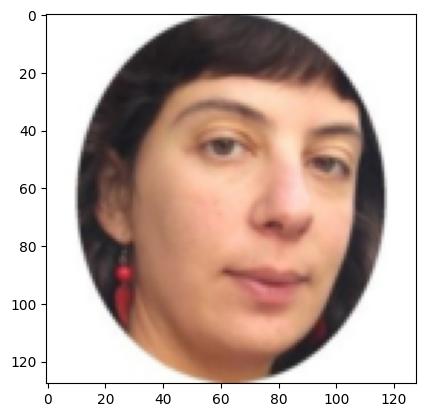

In [28]:
# 代码4-14：模型预测
# 挑选valloader中的第一张图片作为测试
dataiter = iter(val_loader)
images, labels = images, labels =next(dataiter)
img = images[0].permute((1, 2, 0))
plt.imshow(img)
# 将测试图片转为一维的列向量
img = torch.from_numpy(img.numpy())
img = img.reshape(1, 128 * 128 * 3)
# 进行正向推断，预测图片所在的类别
with torch.no_grad():
    output = logisticregression_model.forward(img.to(device))
    
ps = torch.exp(output)
top_p, top_class = ps.topk(1, dim=1)
labellist = ['女性','男性']
prediction = labellist[top_class]
probability = float(F.softmax(output).max())
print(f'神经网络猜测图片里是{prediction}，概率为{probability * 100}%')

## 多分类案例：Fashion-MNIST数据集

In [29]:
# 代码4-15： 获取数据
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((28, 28)), # 变形为网络所需的输入形状（ 28 * 28）
    transforms.ToTensor() # 转换为tensor（注意，此处的tensor默认在CPU上储存）
])

## 获得训练数据的Dataset
train_set = datasets.FashionMNIST('../dataset/', download=True, train=True, transform=transform)

## 获得验证数据的Dataset
val_set = datasets.FashionMNIST('../dataset/', download=True, train=False, transform=transform)

In [30]:
# 代码：4-16 构建训练集和验证集
import torch
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size, shuffle=True, num_workers=4)  # 训练集进行打乱
val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=batch_size, shuffle=False, num_workers=4)  # 测试集不进行打乱

torch.Size([8, 1, 28, 28])
torch.Size([8])


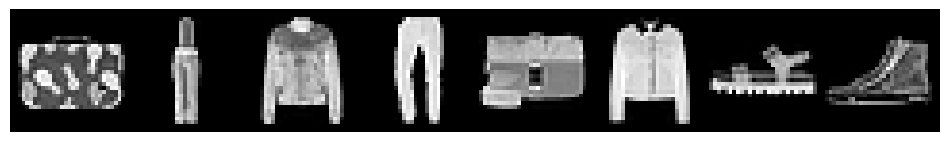

In [31]:
# 代码4-17： 展示训练集中的图片
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
images, labels = next(iter(train_loader))  # 获取训练集第一个批次中的图片及相应标签
print(images.shape)
print(labels.shape)
plt.figure(figsize=(12, 20))  # 设置画布大小
plt.axis('off')  # 隐藏坐标轴
plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))  # make_grid函数把多张图片一起显示，permute函数调换channel维的顺序
plt.show()

In [35]:
# 代码：4-18 构建分类网络
import torch  # 导入pytorch
from torch import nn, optim  # 导入神经网络与优化器对应的类
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)     
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

## 查看模型具体信息
from torchsummary import summary  # 需要预先下载，在终端输入 pip install torchsummary
IMSIZE = 28
classifier_model = Classifier().cuda()
summary(classifier_model, (1, IMSIZE, IMSIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
           Dropout-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
           Dropout-6                   [-1, 64]               0
            Linear-7                   [-1, 10]             650
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.93
Estimated Total Size (MB): 0.94
----------------------------------------------------------------


In [36]:
# 代码4-19： 训练、验证Classifier模型
device = "cuda" # 使用gpu设备进行训练验证
def accuracy(outputs, labels):
    preds = torch.max(outputs, dim=1)[1]  # 获取预测类别
    return torch.sum(preds == labels).item() / len(preds)  # 计算准确率

# 模型验证
def validate(model, val_loader):
    val_loss = 0
    val_acc = 0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
        outputs = model(inputs)  # 计算模型输出
        loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
        val_loss += loss.item()  # item方法提取出tensor中的数字
        acc = accuracy(outputs, labels)  # 计算准确率
        val_acc += acc
    val_loss /= len(val_loader)  # 计算平均损失
    val_acc /= len(val_loader)  # 计算平均准确率
    return val_loss, val_acc

# 打印训练结果
def print_log(epoch, train_time, train_loss, train_acc, val_loss, val_acc, epochs = 10):
    print(f"Epoch [{epoch}/{epochs}], time: {train_time:.2f}s, loss: {train_loss:.4f}, acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

# 定义主函数：模型训练
import time
def train(model, optimizer, train_loader, val_loader, epochs=1):
    train_losses = []; train_accs = [];
    val_losses = []; val_accs = [];
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        train_acc = 0
        start = time.time()  # 记录本epoch开始时间
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
            optimizer.zero_grad()  # 将模型所有参数tensor的梯度变为0（否则之后计算的梯度会与先前存在的梯度叠加）
            outputs = model(inputs)  # 计算模型输出
            loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
            train_loss += loss.item()  # item方法提取出tensor中的数字
            acc = accuracy(outputs, labels)  # 计算准确率
            train_acc += acc
            loss.backward()  # 调用PyTorch的autograd自动求导功能，计算loss相对于模型各参数的导数
            optimizer.step()  # 根据模型中各参数相对于loss的导数，以及指定的学习率，更新参数
        end = time.time()  # 记录本epoch结束时间
        train_time = end - start  # 计算本epoch的训练耗时 
        train_loss /= len(train_loader)  # 计算平均损失
        train_acc /= len(train_loader)  # 计算平均准确率 
        val_loss, val_acc = validate(model, val_loader)  # 计算测试集上的损失函数和准确
        train_losses.append(train_loss); train_accs.append(train_acc)
        val_losses.append(val_loss); val_accs.append(val_acc) 
        print_log(epoch+1, train_time, train_loss, train_acc, val_loss, val_acc, epochs=epochs)  # 打印训练结果
    return train_losses, train_accs, val_losses, val_accs

lr = 1e-3
epochs = 10
optimizer = torch.optim.Adam(classifier_model.parameters(), lr=lr)  # 设置优化器
history = train(classifier_model, optimizer, train_loader, val_loader, epochs=epochs)

Epoch [1/10], time: 32.26s, loss: 0.5837, acc: 0.7856, val_loss: 0.4559, val_acc: 0.8316
Epoch [2/10], time: 28.87s, loss: 0.3900, acc: 0.8577, val_loss: 0.4166, val_acc: 0.8531
Epoch [3/10], time: 29.80s, loss: 0.3458, acc: 0.8740, val_loss: 0.4259, val_acc: 0.8521
Epoch [4/10], time: 29.99s, loss: 0.3250, acc: 0.8803, val_loss: 0.3797, val_acc: 0.8607
Epoch [5/10], time: 29.05s, loss: 0.3057, acc: 0.8865, val_loss: 0.3678, val_acc: 0.8748
Epoch [6/10], time: 29.47s, loss: 0.2944, acc: 0.8914, val_loss: 0.3618, val_acc: 0.8756
Epoch [7/10], time: 30.28s, loss: 0.2829, acc: 0.8958, val_loss: 0.3500, val_acc: 0.8801
Epoch [8/10], time: 30.14s, loss: 0.2731, acc: 0.8981, val_loss: 0.3830, val_acc: 0.8766
Epoch [9/10], time: 28.85s, loss: 0.2666, acc: 0.9010, val_loss: 0.4077, val_acc: 0.8718
Epoch [10/10], time: 28.81s, loss: 0.2596, acc: 0.9039, val_loss: 0.3751, val_acc: 0.8816


神经网络猜测图片里是 靴子，概率为99.9762237071991%


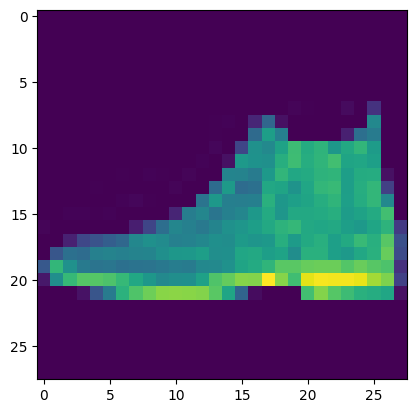

In [38]:
# 代码：4-20 模型预测
# 挑选val_loader中的一张图片作为测试
dataiter = iter(val_loader)
images, labels = images, labels =next(dataiter)
img = images[0]
img = img.permute((1, 2, 0))
plt.imshow(img.squeeze())
# 将测试图片转为一维的列向量
img = torch.from_numpy(img.reshape((28, 28)).numpy())
img = img.view(1, 784)
# 进行正向推断，预测图片所在的类别

with torch.no_grad():
    output = classifier_model.forward(img.to(device))
    
ps = torch.exp(output)
top_p, top_class = ps.topk(1, dim=1)
labellist = ['T恤','裤子','套衫','裙子','外套','凉鞋','汗衫','运动鞋','包包','靴子']
prediction = labellist[top_class]
probability = float(F.softmax(output, dim = 1).max())
print(f'神经网络猜测图片里是 {prediction}，概率为{probability * 100}%')